In [614]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from scipy.stats import boxcox_normmax
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#from mlxtend.regressor import StackingCVRegressor
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import cluster_fun

from sklearn.ensemble import VotingRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures


import statsmodels.api as sm


In [615]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#FUNCTIONS ==============================================================================================

def evaluate_model(model, x, y, folds):
    print("Accuracy: ",round(model.score(x, y),4))
    ypred = cross_val_predict(model, x, y, cv = folds, n_jobs = -1)
    ypred = np.exp(ypred)
    y = np.exp(y)
    print("RMSLE = ", round(np.sqrt(mean_squared_log_error(ypred, y )),4) )
    scores   = -cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv = folds)
    print("Cross-Val Score =",round(np.mean(scores**.5)))
   
def knn(xTrain,xTest,k=5):
    """
    Finds the k nearest neighbors of xTest in xTrain.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    dists = distances between all xTrain and all XTest points. Size of n x m
    indices = k x m matrix with the indices of the yTrain labels that represent the point
    @: is the equivalent of the dot product
    """
    #the following formula calculates the Euclidean distances.
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis] 
    #because of numpy precision, some really small numbers might become negatives.
    #so, we need to replace all negative numbers with zero.
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0) #get indices of sorted items
    distances = np.sort(distances,0) #distances sorted in axis 0
    #returning the top-k closest distances.
    return indices[0:k, : ], distances[0:k, : ]

def knn_predictions(xTrain,yTrain,xTest,k):
    """
    Input:
    xTrain = n x d matrix. n=rows and d=features
    yTrain = n x 1 array. n=rows with label value
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    predictions = predicted labels, ie preds(i) is the predicted label of xTest(i,:)
    """
    indices, distances = knn(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell=indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(np.mean(temp)) #this is the key function, brings the mode value
    predictions=np.array(predictions)
    return predictions

In [616]:
'''
df_neighbldg = df[:1460][["Neighborhood", "BldgType", "SalePrice", "LivingArea"]]
df_neighbldg['psqft'] = df_neighbldg["SalePrice"]/df_neighbldg["LivingArea"]
print(df_neighbldg)
df_neighbldg = df_neighbldg.groupby(["Neighborhood", "BldgType"]).agg({'psqft' : ['mean']})

df_neighbldg=df_neighbldg.reset_index()
df_neighbldg.columns

df_neighbldg.columns = ['Neighborhood', "BldgType", 'MeanPsqft']

df_neighbldg

df = pd.merge(df, df_neighbldg, on=['Neighborhood','BldgType'])

'''

'\ndf_neighbldg = df[:1460][["Neighborhood", "BldgType", "SalePrice", "LivingArea"]]\ndf_neighbldg[\'psqft\'] = df_neighbldg["SalePrice"]/df_neighbldg["LivingArea"]\nprint(df_neighbldg)\ndf_neighbldg = df_neighbldg.groupby(["Neighborhood", "BldgType"]).agg({\'psqft\' : [\'mean\']})\n\ndf_neighbldg=df_neighbldg.reset_index()\ndf_neighbldg.columns\n\ndf_neighbldg.columns = [\'Neighborhood\', "BldgType", \'MeanPsqft\']\n\ndf_neighbldg\n\ndf = pd.merge(df, df_neighbldg, on=[\'Neighborhood\',\'BldgType\'])\n\n'

In [617]:
train = pd.read_csv('train.csv').set_index('Id')
test = pd.read_csv('test.csv').set_index('Id')
test['SalePrice'] = -1
df = pd.concat([train,test], axis=0)
#full_set.to_csv('full_set.csv')
#full_set = full_set[train.columns]

#DATA PROCESSING ========================================================================================


train_part = df[1:1461]


import itertools
n = set(df['Neighborhood'])
l = set(df['LotConfig'])
combinations = list(itertools.product(n,l))
combinations
imputation_dict = train_part[train_part['LotFrontage'].notnull()].groupby(['Neighborhood'
                                                        ,'LotConfig'])[['LotFrontage']].mean().round(2).to_dict()
for key in combinations:
    if key in imputation_dict['LotFrontage'].keys():
        pass
    else:
        imputation_dict['LotFrontage'][(key[0], key[1])] = train_part[(train_part['Neighborhood'] == key[0]) 
                                & (train_part['LotFrontage'].notnull())][['LotFrontage']].mean().round(2).to_dict()['LotFrontage']
impute_index = df['LotFrontage'].isnull()
df.loc[impute_index,'LotFrontage'] = df[impute_index].apply(lambda x:
                                    imputation_dict['LotFrontage'][(x['Neighborhood'], x['LotConfig'])], axis =1)
#full_set['LotFrontage'].isna().sum()


#df['LotFrontage'] = np.where((df['LotFrontage'].isna()),
 #                            ((np.log(df['LotArea'])* 0.5307)-0.6276),
  #                           df['LotFrontage'])
#df['LotFrontage'] = np.log(df['LotFrontage'])


df['TotalBsmtSF'] = np.where((df['TotalBsmtSF'].isna()),0,df['TotalBsmtSF'])

df['MSZoning'] = np.where((df['MSZoning'].isna()),df['MSZoning'].mode(),df['MSZoning'])
df['Exterior1st'] = np.where((df['Exterior1st'].isna()),df['Exterior1st'].mode(),df['Exterior1st'])
df['SaleType'] = np.where((df['SaleType'].isna()),df['SaleType'].mode(),df['SaleType'])
df['GarageType'] = np.where((df['GarageType'].isna()),'None',df['GarageType'])

df['BsmtFinSF1'] = np.where((df['BsmtFinSF1'].isna()),0,df['BsmtFinSF1'])

df['BsmtFinSF1'] = np.where((df['BsmtFinSF1'].isna()),0,df['BsmtFinSF1'])
df['BsmtFinSF2'] = np.where((df['BsmtFinSF2'].isna()),0,df['BsmtFinSF2'])
df['BsmtUnfSF'] = np.where((df['BsmtUnfSF'].isna()),0,df['BsmtUnfSF'])
df['BsmtFullBath'] = np.where((df['BsmtFullBath'].isna()),0,df['BsmtFullBath'])
df['BsmtHalfBath'] = np.where((df['BsmtHalfBath'].isna()),0,df['BsmtHalfBath'])
df['MasVnrArea'] = np.where((df['MasVnrArea'].isna()),0,df['MasVnrArea'])
df['GarageCars'] = np.where((df['GarageCars'].isna()),0,df['GarageCars'])


df['GarageArea'] = np.where((df['GarageArea'].isna()),df.loc[(df['GarageType']=='Detchd'),'GarageArea'].mean(),df['GarageArea'])

df['Garage'] = 0
df['Garage'] = np.where((df['GarageType'] == 'BuiltIn'),1,df['Garage'])
df['Garage'] = np.where((df['GarageType'] == 'Basment'),1,df['Garage'])
df['Garage'] = np.where((df['GarageType'] == '2Types'),0.5,df['Garage'])

df['LivingArea'] = df['TotalBsmtSF']+df['GrLivArea']+df['GarageArea']*df['Garage']

df['ConstArea'] = df['1stFlrSF']+df['GarageArea']*df['Garage']

df['Yard'] = 0
df['Yard'] = df['LotArea']-df['ConstArea']

df['YardPerc'] = df['ConstArea']/df['LotArea']

df['Bathrooms'] = df['FullBath'] + df['HalfBath']

df['Pool'] = 0
df['Pool'] = np.where((df['PoolArea'] > 0), 0, 1)

df['ConstCost'] = df['GrLivArea'] * 100 + 4 * df['LotArea']

df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
#then drop the individual columns. Paul has done this in his script, but if you want to test it already this is in line with your code...

temp_dict = dict([['StoneBr1Fam',90.4395973747988],['StoneBrTwnhsE',64.9650413081317],['NridgHt1Fam',80.1543151289586],['NridgHtTwnhs',65.1602983195312],['NridgHtTwnhsE',69.1353791634465],['NoRidge1Fam',72.0738507675531],['Veenker1Fam',66.0429078276295],['VeenkerTwnhsE',80.5042194092827],['Gilbert1Fam',68.3854903542442],['Gilbert2fmCon',54.0234724292101],['Somerst1Fam',68.2144072973843],['SomerstTwnhs',63.2701103604549],['SomerstTwnhsE',67.1788824758477],['Timber1Fam',66.7389414909238],['Timber2fmCon',60.0288411116938],['TimberTwnhsE',68.7389414909238],['Crawfor1Fam',66.3725911426128],['Crawfor2fmCon',54.5893602225313],['CrawforDuplex',42.227593738624],['CrawforTwnhsE',80.6373302358828],['CollgCr1Fam',62.6262950167203],['CollgCrDuplex',47.6262950167203],['CollgCrTwnhsE',67.8023156899811],['ClearCr1Fam',61.2119033661411],['ClearCrTwnhs',58.2119033661411],['SawyerW1Fam',61.1450936373841],['SawyerWDuplex',55.8753295978906],['SawyerWTwnhsE',54.9017441230636],['Blmngtn1Fam',54.7578767123288],['BlmngtnTwnhsE',60.150351985043],['NWAmes1Fam',56.301293015552],['NWAmes2fmCon',43.301293015552],['NWAmesDuplex',35.2847132104853],['BluesteTwnhs',55.431718061674],['BluesteTwnhsE',55.0603907637655],['Mitchel1Fam',57.6274194214023],['Mitchel2fmCon',47.3372781065089],['MitchelDuplex',46.4664009742057],['MitchelTwnhs',57.8687367678193],['MitchelTwnhsE',55.5553243149497],['BrkSide1Fam',55.1598006041819],['BrkSide2fmCon',51.792828685259],['NPkVillTwnhs',53.7742170429716],['NPkVillTwnhsE',54.6368773137624],['Sawyer1Fam',54.9031233267892],['Sawyer2fmCon',50.9279628195197],['SawyerDuplex',41.0229742817174],['NAmes1Fam',53.9106785412273],['NAmes2fmCon',71.9039548022599],['NAmesDuplex',42.0147234693277],['NAmesTwnhsE',61.4473581213307],['BrDaleTwnhs',53.5906850987746],['BrDaleTwnhsE',47.9123945489942],['Edwards1Fam',50.1959140532244],['Edwards2fmCon',49.3992365555181],['EdwardsDuplex',56.7003610108303],['EdwardsTwnhs',43.3146997929607],['EdwardsTwnhsE',71.0762529983588],['MeadowVTwnhs',57.2698772426818],['MeadowVTwnhsE',47.9567654841458],['SWISU1Fam',49.4898887276246],['SWISU2fmCon',49.8638511814982],['SWISUDuplex',41.6768699545614],['OldTown1Fam',49.2350787555647],['OldTown2fmCon',41.1327129667974],['OldTownDuplex',47.7662535079514],['IDOTRR1Fam',45.1213106618607],['IDOTRR2fmCon',58.958157227388],['IDOTRRDuplex',51.2104283054004]])
df['neigh_BldgType'] = list(map(lambda x,y: temp_dict[str(x) + str(y)],df['Neighborhood'],df['BldgType']))

In [618]:
#Convert into string Categorical Columns
df.MSSubClass = df.MSSubClass.astype(str)
#df.OverallQual = df.OverallQual.astype(str)
#df.OverallCond = df.OverallCond.astype(str)
df.YrSold = df.YrSold.astype(str)
df.MoSold = df.MoSold.astype(str)

#Eliminated LotFrontage and GarageYrBuilt
cols_to_keep = ['MSSubClass', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd',
       'RoofStyle',
       'RoofMatl', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'LowQualFinSF',
       'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
       'neigh_BldgType',
       'LivingArea',
#       'ConstCost',
#       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 
       'MoSold', 'SaleType', 'SaleCondition', 'SalePrice', 'Garage',
       'YardPerc', 'Bathrooms','TotalPorch','LotFrontage']


data = df[cols_to_keep]
#data = df[:]


In [619]:
categorical = []
numerical = []

for col in data.columns:
    if data[col].dtype in ['object']:
        categorical.append(col)
    else:
        numerical.append(col)
            
columns_to_square = ['LotArea','TotalBsmtSF','GrLivArea']
#SQUARE OF VARIABLES
for col in columns_to_square:
    new_col = str(col) + "_sq"
    data[new_col] = np.log(data[col]+1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [620]:
#print(data.columns)
sc = data.sort_values(by=['SalePrice'])['SaleCondition']
mssub = data.sort_values(by=['SalePrice'])['MSSubClass'] 
st = data.sort_values(by=['SalePrice'])['SaleType'] 
ms = data.sort_values(by=['SalePrice'])['MoSold'] 
lc = data.sort_values(by=['SalePrice'])['LotConfig']
bldgtype = data.sort_values(by=['SalePrice'])['BldgType']
oq =  data.sort_values(by=['SalePrice'])['OverallQual']
nbhd =  data.sort_values(by=['SalePrice'])['Neighborhood']

In [621]:
'''
trainData = data[:1460]
trainData['spgla'] = trainData.SalePrice/trainData.GrLivArea

kdf = cluster_fun.cluster(4, trainData[['Neighborhood', 'spgla']]) #n tot = 25
data = cluster_fun.kReplace(data.reset_index(), kdf, 'Neighborhood', 'spgla')

categorical.remove('Neighborhood')
data = data.drop(['Neighborhood'], axis = 1)

'''

"\ntrainData = data[:1460]\ntrainData['spgla'] = trainData.SalePrice/trainData.GrLivArea\n\nkdf = cluster_fun.cluster(4, trainData[['Neighborhood', 'spgla']]) #n tot = 25\ndata = cluster_fun.kReplace(data.reset_index(), kdf, 'Neighborhood', 'spgla')\n\ncategorical.remove('Neighborhood')\ndata = data.drop(['Neighborhood'], axis = 1)\n\n"

In [622]:
#Dummies ===========================================================================

data = pd.get_dummies(data, prefix_sep = '_', columns=categorical, drop_first = True)
np.sum(data.isna())
#numerical_columns = list(set(cols_to_keep).difference(set(categorical_columns)))

data= data.drop([31,411,524,534,592,677,689,804,1047,1299])
data= data.drop([363,390,496,633,729,770,899,969,1063,1182])

data= data.drop([250, 314, 336, 707])

#KNN
y_knn = np.array(data['SalePrice'] / data['GrLivArea'])
y_knn = y_knn[y_knn > 0]

x_knn = pd.DataFrame()
x_knn['GrLivArea'] = data['GrLivArea'][data['SalePrice']>0]
x_knn['OverallQual'] = 1
xTe_knn = pd.DataFrame()
xTe_knn['GrLivArea'] = data['GrLivArea'][data['SalePrice']<=0]
xTe_knn['OverallQual'] = 1

x_knn = np.array(x_knn)
xTe_knn = np.array(xTe_knn)
y_knn = np.array(y_knn)

#indices, distances = knn(x_knn,x_knn,5)
#knn_preds_train = knn_predictions(xTrain,yTrain,xTest,k):
knn_preds_train = knn_predictions(x_knn,y_knn,x_knn,5)
knn_preds_test = knn_predictions(x_knn,y_knn,xTe_knn,5)

data['knn_GrLivArea'] = np.array(pd.concat([pd.DataFrame(knn_preds_train),pd.DataFrame(knn_preds_test)]))

yTr = data.SalePrice[data['SalePrice']>=0]
xTr = data[data['SalePrice']>=0].drop(['SalePrice'], axis=1)
xTe = data[data['SalePrice']==-1].drop(['SalePrice'], axis=1)


In [623]:
x = xTr[:]
y = np.log(yTr[:])

#==================================================================================


np.random.seed(0)
print("\nLinear","- "*20)
ols = linear_model.LinearRegression()
ols.fit(x, y)
evaluate_model(ols, x, y, 5)


Linear - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9516
RMSLE =  0.1116
Cross-Val Score = 22644.0


In [640]:
y = np.array(y).flatten()
x = np.array(x).reshape(-1,1)

lowess = sm.nonparametric.lowess(x,y, frac=.3)

ValueError: endog must be a vector

In [384]:
np.random.seed(1)
print("\nRidge","- "*20)
ridge = linear_model.RidgeCV(   alphas=np.arange(0.05,4,0.01),
                                normalize=[True,False],
                                fit_intercept=[True,False])
ridge.fit(x, y)
#best_alpha = ridge.alpha_
#print("Best alpha = ",best_alpha)
#ridge = linear_model.Ridge(ridge.alpha_,normalize=True)
#ridge.fit(x, y)
evaluate_model(ridge, x, y, 5)


print("\nLasso","- "*20)
lasso = linear_model.LassoCV(eps=0.001, n_alphas=100, cv=5, normalize=True, max_iter=1000000)
lasso.fit(x, y)
print("Best alpha = ",lasso.alpha_)
evaluate_model(lasso, x, y, 5)




Ridge - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9472
RMSLE =  0.1066
Cross-Val Score = 22694.0

Lasso - - - - - - - - - - - - - - - - - - - - 
Best alpha =  6.77150050408989e-05
Accuracy:  0.9428
RMSLE =  0.1025
Cross-Val Score = 21902.0


In [385]:

print("\nElasticNet","- "*20)

elastic = linear_model.ElasticNetCV(  l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
                            eps=0.001,
                            n_alphas=100,
                            fit_intercept=True,
                            normalize=True,
                            precompute='auto',
                            max_iter=10000,
                            tol=0.00001,
                            cv=5, n_jobs=-1, positive=False)

elastic.fit(x, y)
#print("Best alpha = ",lasso.alpha_)
evaluate_model(elastic, x, y, 5)


ElasticNet - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9426
RMSLE =  0.1028
Cross-Val Score = 21904.0


In [386]:
np.random.seed(0)
print("\nGBoosting","- "*20)
boost = GradientBoostingRegressor(n_estimators = 500)
boost.fit(x, y)
evaluate_model(boost, x, y, 5)


np.random.seed(0)
param_grid = [
    {'subsample':[0.5,1],
    'learning_rate':[0.025,0.05,0.1],
    'max_depth':[2,3,4],
    'loss':['huber'],
    'n_estimators':[500]}
            ]
#boost = GradientBoostingRegressor()
grid_search = GridSearchCV(boost,param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True, n_jobs=-1)
np.random.seed(0)
grid_search.fit(x,y)
#print(grid_search.best_params_)
print("\nGBoosting 2","- "*20)
boost2 = grid_search.best_estimator_
boost2.fit(x, y)

evaluate_model(boost2, x, y, 5)


GBoosting - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9894
RMSLE =  0.1112
Cross-Val Score = 20151.0

GBoosting 2 - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9738
RMSLE =  0.1059
Cross-Val Score = 19867.0


In [387]:
poly = PolynomialFeatures()
poly.fit_transform(x,y)
polyy = poly.predict(xTe)
#evaluate_model(poly, x, y, 5)

AttributeError: 'PolynomialFeatures' object has no attribute 'predict'

In [388]:
print("\nEnsemble - VotingRegressor","- "*20)
ereg = VotingRegressor(estimators=[ ('gb2', boost2),
                                    ('gb', boost),
                                    ('lr', ridge),
                                    ('ls', lasso)],
                                    weights=[0.3, 0.3, 0.2, 0.2],
                                    n_jobs = -1)
ereg.fit(x, y)
ereg.predict(xTe)
evaluate_model(ereg, x, y, 5)




Ensemble - VotingRegressor - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9741
RMSLE =  0.101
Cross-Val Score = 19075.0


In [154]:
pd.DataFrame(np.exp(ereg.predict(xTe))).to_csv('eregpredneweights.csv')

In [393]:
'''
temp = pd.DataFrame(ereg.predict(xTe))
temp = ((temp*transf_yTr_lambda)+1)**(1/transf_yTr_lambda)
idx = range(1461,2920)
temp.index=idx
temp=temp.reset_index()
temp.columns=['Id','SalePrice']
temp.to_csv('ereg.csv',index=False)


lmbda=transf_yTr_lambda
prediction = pd.DataFrame()
prediction['ols'] = np.exp(ols.predict(xTr),lmbda)
prediction['ridge'] = np.exp(ridge.predict(xTr),lmbda)
prediction['lasso'] = np.exp(lasso.predict(xTr),lmbda)
prediction['elastic'] = np.exp(elastic.predict(xTr),lmbda)
prediction['boost'] = np.exp(boost.predict(xTr),lmbda)
prediction['boost2'] = np.exp(boost2.predict(xTr),lmbda)
prediction['ereg'] = np.exp(ereg.predict(xTr),lmbda)
prediction['y'] = np.exp(yTr,lmbda)
prediction.to_csv('prediction_train.csv')
'''

prediction_xte = pd.DataFrame()
prediction_xte['ols'] = np.exp(ols.predict(xTe))
prediction_xte['ridge'] = np.exp(ridge.predict(xTe))
prediction_xte['lasso'] = np.exp(lasso.predict(xTe))
prediction_xte['elastic'] = np.exp(elastic.predict(xTe))
prediction_xte['boost'] = np.exp(boost.predict(xTe))
prediction_xte['boost2'] = np.exp(boost2.predict(xTe))
prediction_xte['ereg'] = np.exp(ereg.predict(xTe))
prediction_xte.to_csv('prediction_test.csv')

In [394]:
#plt.figure()
corr = data.corr()
corr.to_csv('corr.csv')
#sns.heatmap(corr)

#==================================================================================

In [398]:
data_graph = data.sort_values(by=['SalePrice'])
yt = data_graph.SalePrice[data['SalePrice']>=0]

sc = sc[yt.index]
mssub = mssub[yt.index]
or_id = yt.index

xt = data_graph[data_graph['SalePrice']>=0].drop(['SalePrice'], axis=1)



In [401]:
data_graph = data.sort_values(by=['SalePrice'])
yt = data_graph.SalePrice[data['SalePrice']>=0]

sc = sc[yt.index]
mssub = mssub[yt.index]
st = st[yt.index]
ms = ms[yt.index]
lc = lc[yt.index]
bldgtype = bldgtype[yt.index]
oq = oq[yt.index]
nbhd = nbhd[yt.index]


or_id = yt.index

xt = data_graph[data_graph['SalePrice']>=0].drop(['SalePrice'], axis=1)


In [641]:
resid_df = pd.DataFrame(yt)


olspaul = pd.read_csv('olspl.csv')
olspaul=olspaul.loc[yt.index]
olspaul = olspaul['SalePrice']

resid_df['Residuals (EREG)'] = pd.DataFrame(np.exp(ereg.predict(xt))-yt)
resid_df['Residuals (Lasso)'] = pd.DataFrame(np.exp(lasso.predict(xt))-yt)
resid_df['Residuals (Ridge)'] = pd.DataFrame(np.exp(ridge.predict(xt))-yt)
resid_df['Residuals (Boost)'] = pd.DataFrame(np.exp(boost.predict(xt))-yt)
resid_df['Residuals (OLS)'] = pd.DataFrame(np.exp(ols.predict(xt))-yt)
resid_df['Residuals (OLS-Paul)']=olspaul - yt

print(resid_df)
resid_df = resid_df.reset_index()

resid_df = resid_df.merge(sc, on = 'Id')
resid_df = resid_df.merge(mssub, on = 'Id')
resid_df = resid_df.merge(st, on = 'Id')
resid_df = resid_df.merge(lc, on = 'Id')
resid_df = resid_df.merge(bldgtype, on = 'Id')
resid_df = resid_df.merge(oq, on = 'Id')
resid_df = resid_df.merge(nbhd, on = 'Id')


resid_df.columns = ['Id', 'Actual Sale Price' ,
                    'EREG', 'Lasso','Ridge', 'Boost', 'OLS', "OLS-Paul",
                    "SaleCondition", 
                    "MSSubClass","SaleType", "LotConfig", "BuildingType", "OverallQual", "Neighborhood"]


resid_df['id2'] = resid_df.index

resid_df = pd.melt(resid_df, id_vars =['Id', 'Actual Sale Price',  "SaleCondition", 
                    "MSSubClass","SaleType", "LotConfig", "BuildingType", "OverallQual", "Neighborhood"], 
        value_vars =["EREG", "Lasso", "Ridge", "Boost", "OLS", "OLS-Paul"])


resid_df['Residuals/Actual Sale Price'] = resid_df['value']/resid_df['Actual Sale Price']

resid_df['Actual Sale Price'] = np.log(resid_df['Actual Sale Price'])

resid_df['SortedIndex'] = resid_df.index



resid_df1 = resid_df[resid_df['variable'].isin(["Lasso","Ridge"])]
sns.lmplot(y = 'Residuals/Actual Sale Price',
           x= "Log Sale Price", hue = "variable", data=resid_df1, fit_reg=False);


      SalePrice  Residuals (EREG)  Residuals (Lasso)  Residuals (Ridge)  \
Id                                                                        
917       35311      10725.061050       34508.108603       40096.728808   
711       52000       4918.335688       25620.166786       33176.949800   
1338      52500       4663.465954       21686.848061       23066.142742   
706       55000       7254.126331         186.288496        5233.837150   
1326      55000       5409.871721       27657.373942       38210.936491   
...         ...               ...                ...                ...   
179      501837     -33883.322978      -65798.592142      -59579.896861   
441      555000      -7716.092512      -40103.023626      -36412.939345   
1170     625000     -22803.732752      -51826.774757      -46608.222126   
1183     745000     -50739.171899      -35877.094877      -92617.926854   
692      755000     -11334.037764      -15140.370723        6766.620881   

      Residuals (Boost) 

KeyError: "['Log Sale Price'] not in index"

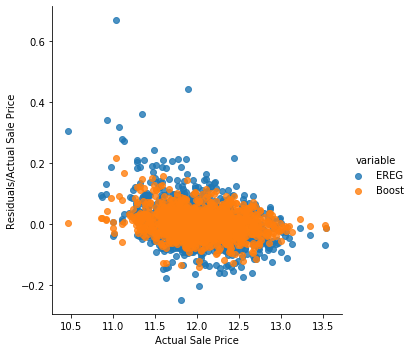

In [403]:
resid_df2 = resid_df[resid_df['variable'].isin(["Boost"])]
sns.lmplot(y = 'Residuals/Actual Sale Price',
           x= "Actual Sale Price", hue = "variable", data=resid_df2, fit_reg=False);

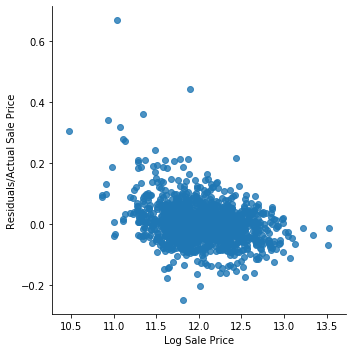

In [667]:
resid_df3 = resid_df[resid_df['variable'].isin(["EREG"])]
ax = sns.lmplot(y = 'Residuals/Actual Sale Price',
           x= "Actual Sale Price", hue = "variable", data=resid_df3, fit_reg=False, legend = False);

ax.set(xlabel='Log Sale Price')

ax.savefig("ereg_residuals.png")

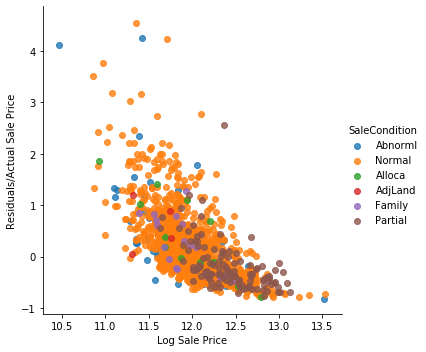

In [668]:
resid_df4 = resid_df[resid_df['variable']=="OLS-Paul"]
ax = sns.lmplot(y = 'Residuals/Actual Sale Price',
           x= "Actual Sale Price", hue = "SaleCondition", data=resid_df4, fit_reg=False);

ax.set(xlabel='Log Sale Price')

ax.savefig("practicalols_salecon_residuals.png")

In [406]:
olspaul = pd.read_csv('olspl.csv')

In [351]:
olspaul = olspaul.loc[yt.index]
olspaul

,SalePrice
Id,
917,180558.8681
711,234854.3974
1338,122298.7234
706,152394.4428
1326,188133.9827
...,...
179,160012.2807
441,120556.9771
1170,156166.3974


In [354]:
olspaul = olspaul['SalePrice']
olspaul

Id
917     180558.8681
711     234854.3974
1338    122298.7234
706     152394.4428
1326    188133.9827
           ...     
179     160012.2807
441     120556.9771
1170    156166.3974
1183    125138.5229
692     213257.5899
Name: SalePrice, Length: 1436, dtype: float64

In [362]:
yt

Id
917      35311
711      52000
1338     52500
706      55000
1326     55000
         ...  
179     501837
441     555000
1170    625000
1183    745000
692     755000
Name: SalePrice, Length: 1436, dtype: int64

In [363]:
yt - olspaul

Id
917    -145247.8681
711    -182854.3974
1338    -69798.7234
706     -97394.4428
1326   -133133.9827
           ...     
179     341824.7193
441     434443.0229
1170    468833.6026
1183    619861.4771
692     541742.4101
Name: SalePrice, Length: 1436, dtype: float64

In [364]:
len(yt)

1436

In [471]:
LAmean = np.mean(data.LivingArea)
LAmean

data_small = data.loc[data.LivingArea<LAmean]
data_big = data.loc[data.LivingArea>LAmean]

In [472]:
yTr_small = data_small.SalePrice[data_small['SalePrice']>=0]
xTr_small = data_small[data_small['SalePrice']>=0].drop(['SalePrice'], axis=1)
xTe_small = data_small[data_small['SalePrice']==-1].drop(['SalePrice'], axis=1)



yTr_big = data_big.SalePrice[data_big['SalePrice']>=0]
xTr_big = data_big[data_big['SalePrice']>=0].drop(['SalePrice'], axis=1)
xTe_big = data_big[data_big['SalePrice']==-1].drop(['SalePrice'], axis=1)


xsmall = xTr_small[:]
ysmall = np.log(yTr_small[:])

xbig = xTr_big[:]
ybig = np.log(yTr_big[:])

In [473]:
np.random.seed(0)
print("\nLinear","- "*20)
ols = linear_model.LinearRegression()
ols.fit(xbig, ybig)
evaluate_model(ols, xbig, ybig, 5)


Linear - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9498
RMSLE =  0.1261
Cross-Val Score = 34109.0


In [474]:
np.random.seed(0)
print("\nLinear","- "*20)
ols = linear_model.LinearRegression()
ols.fit(xsmall, ysmall)
evaluate_model(ols, xsmall, ysmall, 5)


Linear - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9088
RMSLE =  0.1172
Cross-Val Score = 13625.0


In [475]:
np.random.seed(1)
print("\nRidge","- "*20)
ridge = linear_model.RidgeCV(   alphas=np.arange(0.05,4,0.01),
                                normalize=[True,False],
                                fit_intercept=[True,False])
ridge.fit(xsmall, ysmall)
#best_alpha = ridge.alpha_
#print("Best alpha = ",best_alpha)
#ridge = linear_model.Ridge(ridge.alpha_,normalize=True)
#ridge.fit(x, y)
evaluate_model(ridge, xsmall, ysmall, 5)


print("\nLasso","- "*20)
lasso = linear_model.LassoCV(eps=0.001, n_alphas=100, cv=5, normalize=True, max_iter=1000000)
lasso.fit(xsmall, ysmall)
print("Best alpha = ",lasso.alpha_)
evaluate_model(lasso, xsmall, ysmall, 5)



Ridge - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.8902
RMSLE =  0.1068
Cross-Val Score = 12820.0

Lasso - - - - - - - - - - - - - - - - - - - - 
Best alpha =  0.00012729909066803923
Accuracy:  0.8824
RMSLE =  0.1034
Cross-Val Score = 12338.0


In [592]:
len(xsmall)
len(ysmall)

788

In [476]:
np.random.seed(1)
print("\nRidge","- "*20)
ridge = linear_model.RidgeCV(   alphas=np.arange(0.05,4,0.01),
                                normalize=[True,False],
                                fit_intercept=[True,False])
ridge.fit(xbig, ybig)
#best_alpha = ridge.alpha_
#print("Best alpha = ",best_alpha)
#ridge = linear_model.Ridge(ridge.alpha_,normalize=True)
#ridge.fit(x, y)
evaluate_model(ridge, xbig, ybig, 5)


print("\nLasso","- "*20)
lasso = linear_model.LassoCV(eps=0.001, n_alphas=100, cv=5, normalize=True, max_iter=1000000)
lasso.fit(xbig, ybig)
print("Best alpha = ",lasso.alpha_)
evaluate_model(lasso, xbig, ybig, 5)



Ridge - - - - - - - - - - - - - - - - - - - - 
Accuracy:  0.9351
RMSLE =  0.1107
Cross-Val Score = 29785.0

Lasso - - - - - - - - - - - - - - - - - - - - 
Best alpha =  0.00016639890488183296
Accuracy:  0.9231
RMSLE =  0.1063
Cross-Val Score = 28134.0


In [610]:
yp_small = lasso.predict(xsmall)
yp_small = np.exp(yp_small)


yp_big = lasso.predict(xbig)
yp_big = np.exp(yp_big)



yp = np.vstack((yp_small.reshape(-1,1), yp_big.reshape(-1,1)))
#yp_small = yp_small.reshape(-1,1)
#yp_big = yp_big.reshape(-1,1)

yreal = ysmall.values
yreal = np.vstack((yreal.reshape(-1,1), ybig.values.reshape(-1,1)))
#yreal = np.vstack((ysmall.values, ybig.values))

In [611]:
yp = yp[:,0]
resid = (yp - np.exp(yreal))/np.exp(yreal)

In [612]:
plotdata = pd.DataFrame(resid)
plotdata['yreal'] = yreal
plotdata.columns = ['resid', 'yreal']
#plotdata['resid'] = resid
#plotdata['yreal'] = pd.DataFrame(yreal)
sns.lmplot(y = "resid", x= "yreal", data = plotdata, fit_reg=False);

ValueError: Length mismatch: Expected axis has 1437 elements, new values have 2 elements

In [575]:
yp

(1436,)

In [459]:
ybig.shape

(648,)

In [613]:
import statsmodels.api as sm